## **AI Chess Master - Computer Vision Final**
**Author:** Ibrahim Sobh

**Instructions:**

This **notebook** includes:
* Data Exploration ✅
* Models Training ✅
* Performance Evaluation ✅
* Saving Model for Production ✅

**Dataset** https://www.kaggle.com/datasets/koryakinp/chess-positions?datasetId=115231/br%3E

###  Importing Libraries


In [2]:
import re
import cv2
import glob
import random as rd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
%matplotlib inline

### 1- Exploratory Data Analysis for data quality review

In [4]:
#Define train path and test path
train_path = glob.glob("./train/*.jpeg")
test_path = glob.glob("./test/*.jpeg")

#Shuffle train and test samples
rd.shuffle(train_path)
rd.shuffle(test_path)

#Decide the number of train and test samples
train_size =20000
test_size = 4000
train = train_path[:train_size]
test= test_path[:test_size]

# Piece_type = ['King','Queen','Rook','Bishop','Knight','Pawn']|
# Capital = White, Normal = Black
piece_symbols = 'prbnkqPRBNKQ'

- Define a function to extract labels/FEN from Images

In [5]:
# Get the labels ( FNE ) for the training and testing images
def get_image_FEN_label(image_path):
    fen_label= image_path.replace('.jpeg', '').split('/')[-1]
    return fen_label

- Display a random sample of the data

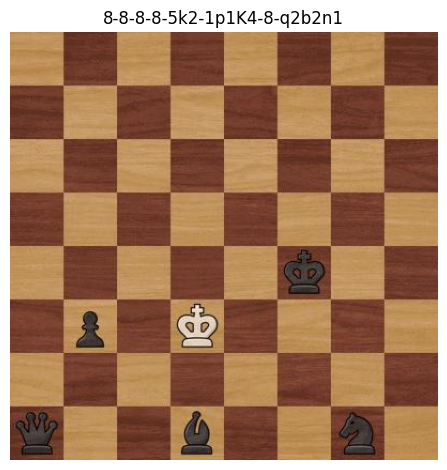

In [6]:
rand = np.random.randint(0, train_size)
img_path =train[rand]
img_moves =  get_image_FEN_label(img_path)
img_rand=cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(img_moves)
plt.axis('off')
plt.tight_layout()
plt.show()

- Check the Python Chess Library to understand the FEN format

In [ ]:
%pip install python-chess

Note: you may need to restart the kernel to use updated packages.


The FEN notation of the image is:  8-8-8-8-5k2-1p1K4-8-q2b2n1


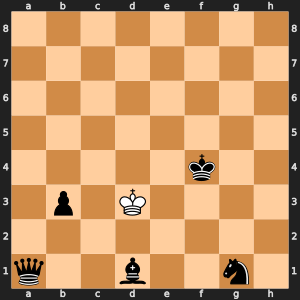

In [7]:
import chess.svg
import chess
print("The FEN notation of the image is: ", img_moves)
board = chess.Board(img_moves.replace('-', '/'))
chess.svg.board(board, size=300)


- Display a bunch of samples of the data

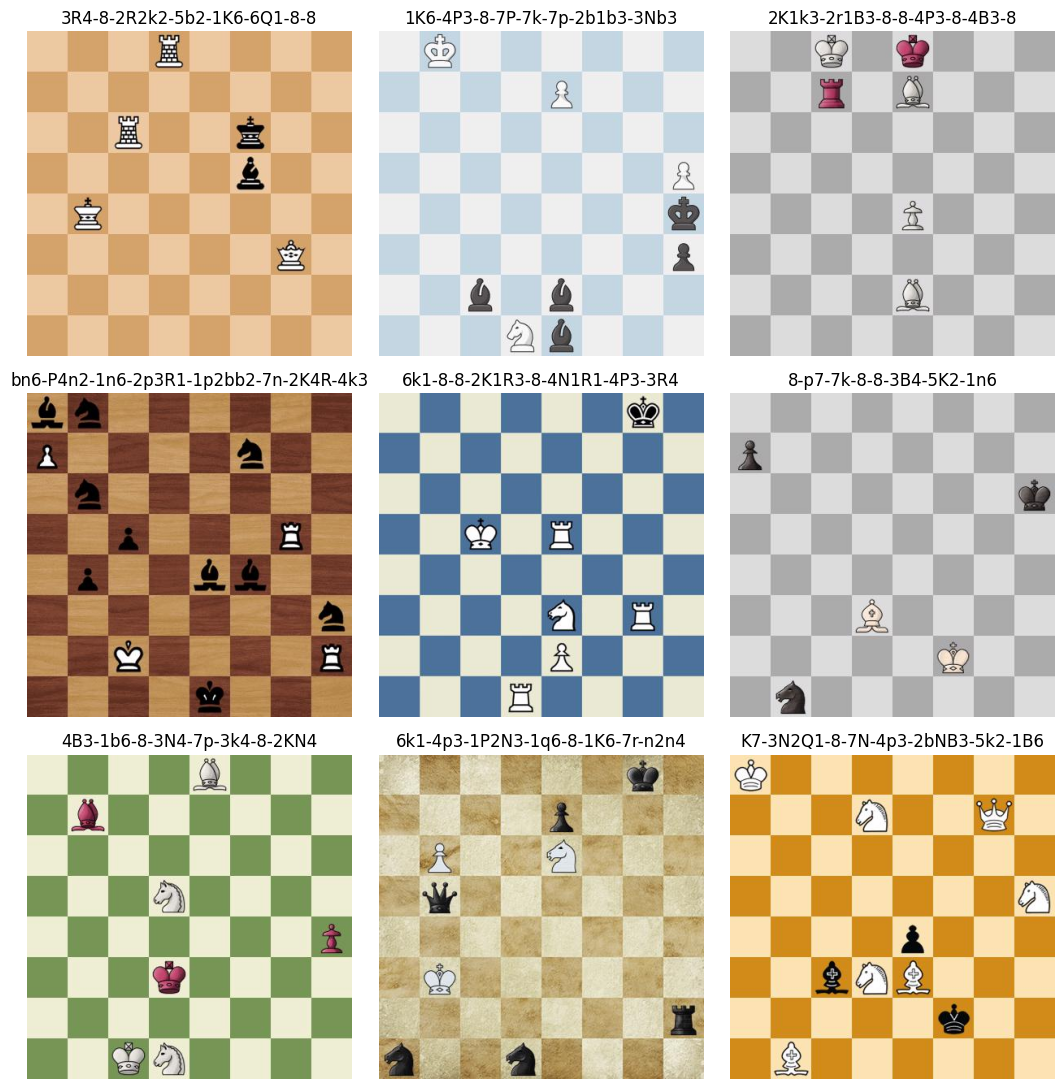

In [8]:
samples =rd.sample(train, 9)
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1),samples ):
    fig.add_subplot(rows, columns, i)
    img_moves =  get_image_FEN_label(img)
    img = cv2.imread(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(img_moves)
    plt.tight_layout()

plt.show()

- Labels distribution - **All labels are Unique**

In [9]:
labels = [get_image_FEN_label(img) for img in train]
set_labels = set(labels)
print("Number of labels {} is equal to number of images {}".format(len(set_labels), len(train)))

Number of labels 20000 is equal to number of images 20000


- Analyzing pictures dimensions and ratio - **Same Ratio, Width, Height for all pictures***

Selected Width X heights: 400X400


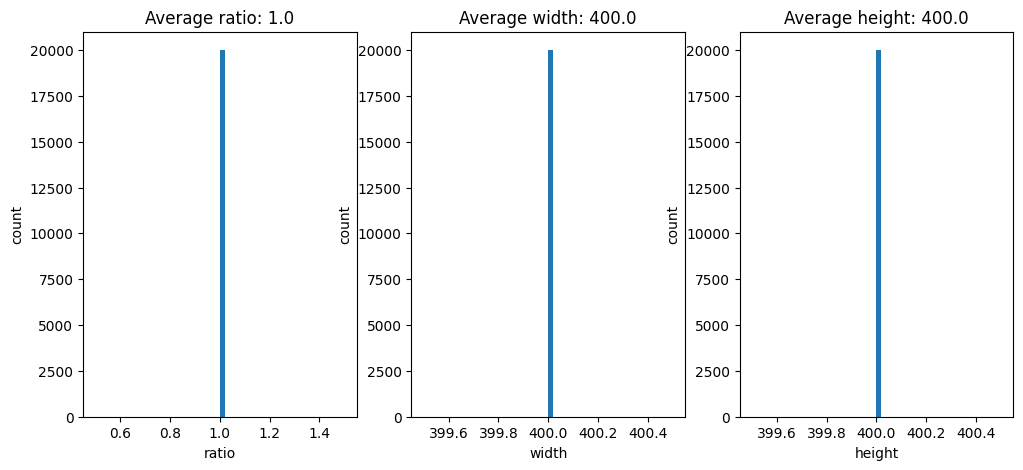

In [10]:
ratios = []
widths = []
heights = []

for img in train:
  img= cv2.imread(img)
  ratios.append(img.shape[1] / img.shape[0])
  heights.append(img.shape[0])
  widths.append(img.shape[1])

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.hist(ratios, bins=50)
ax1.set_xlabel('ratio')
ax1.set_ylabel('count')
ax1.set_title('Average ratio: {}'.format(np.mean(ratios)))

ax2.hist(widths, bins=50)
ax2.set_xlabel('width')
ax2.set_ylabel('count')
ax2.set_title('Average width: {}'.format(np.mean(widths)))

ax3.hist(heights, bins=50)
ax3.set_xlabel('height')
ax3.set_ylabel('count')
ax3.set_title('Average height: {}'.format(np.mean(heights)))

print("Selected Width X heights: {}X{}".format(int(np.mean(widths)) ,int(np.mean(heights))))

### 2 - Data Preprocessing

### 2.B - Resizing, Scaling, Normalization, etc.

- Create a function to Greyscale,Resize and Normalize the data

In [11]:
def preprocess_some_images(img_paths, width, height):
  resized_imgs = []
  for img_path in img_paths:
    # change to Grey scal
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

    # resize the image to the desired size
    gray_image = cv2.resize(img, (width, height))

    # Normalize the image
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    # add to the list
    resized_imgs.append(gray_image)

  return resized_imgs

In [12]:
preprocessed_imgs= preprocess_some_images(samples,240,240)

- Display new image HxW dimensions

In [13]:
"{}X{}".format(preprocessed_imgs[0].shape[0],preprocessed_imgs[0].shape[1])


'240X240'

- Display new image shape

In [14]:
preprocessed_imgs[0].shape

(240, 240, 3)

- Data Diplay - **Greyscale, Resized and Normalized**

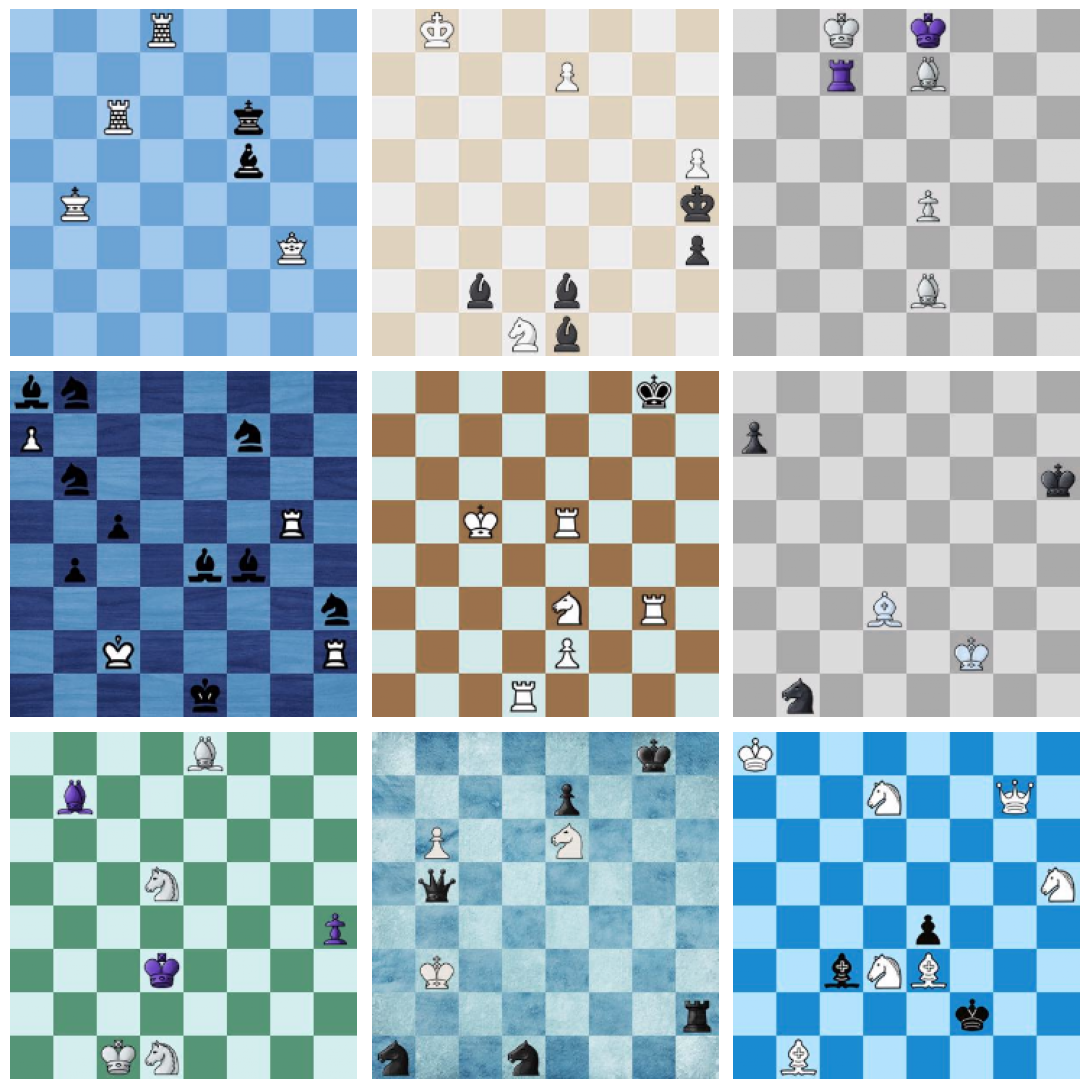

In [15]:
fig = plt.figure(figsize=(11, 11))
columns = 3
rows = 3
for i, img in zip(range(1, columns*rows +1), preprocessed_imgs):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()

### 2.B - PCA Analysis

1. On the Complete Chess Board

- Prepare Image Data for PCA Analysis

(720, 720)

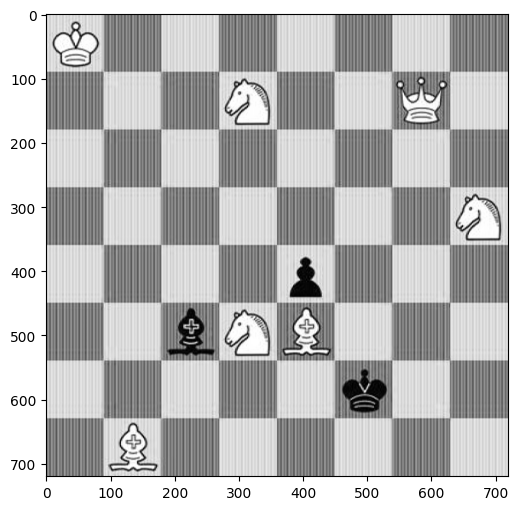

In [16]:
img = np.array(cv2.imread(samples[8]))
new_img=img.reshape(img.shape[0], (img.shape[1]*img.shape[2]))
new_img= cv2.resize(new_img, (720, 720),interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(6, 6))
plt.imshow(new_img, cmap='gray')
new_img.shape



- PCA Analysis - **Components Analysis**

Using 15 components reservers 93.10000000000001% of the features


Text(0, 0.5, 'Cumulative_explained_variance')

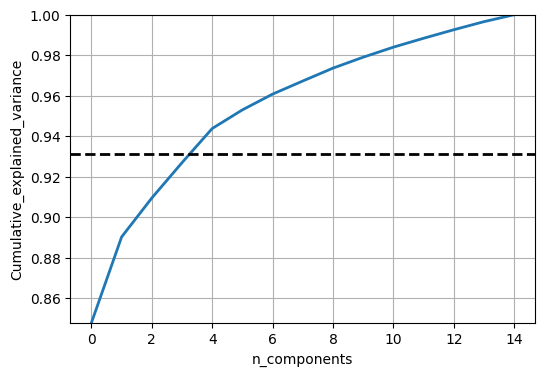

In [17]:
#Import required modules
from sklearn.decomposition import PCA

pca = PCA()
pca.n_components = 15
img_transformed = pca.fit_transform(new_img)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

reserved =np.round(np.sum(pca.explained_variance_ratio_),3)*100

print("Using {} components reservers {}% of the features".format(pca.n_components,reserved))

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylim(min(cum_var_explained),1)
plt.axhline(y=reserved/100.0, linestyle='--', color='k', linewidth=2)
plt.ylabel('Cumulative_explained_variance')



- PCA Analysis - **Results**

Text(0.5, 1.0, 'After PCA image')

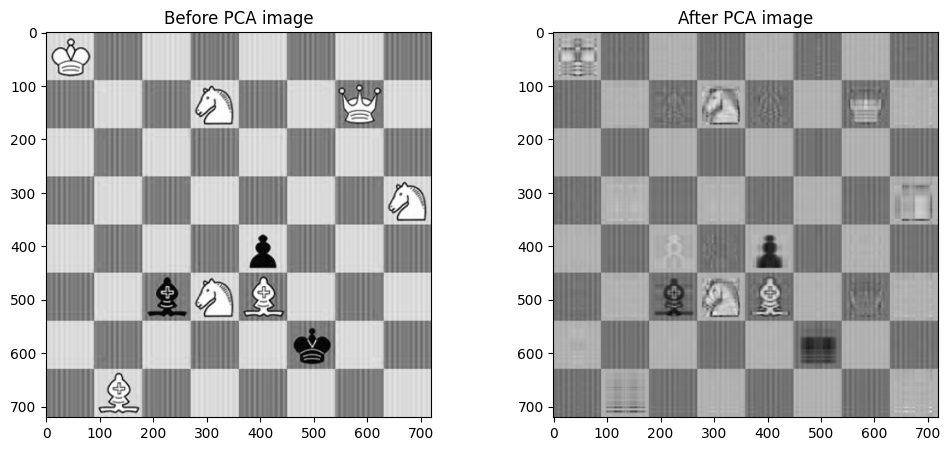

<Figure size 600x600 with 0 Axes>

In [18]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
img = np.array(cv2.imread(samples[8]))##np.array(preprocessed_imgs[0],copy=True)
new_img=img.reshape(img.shape[0], (img.shape[1]*img.shape[2]))
new_img= cv2.resize(new_img, (720, 720),interpolation=cv2.INTER_CUBIC)
ax1.imshow(new_img, cmap='gray')
ax1.set_title("Before PCA image")

plt.figure(figsize=(6, 6))
temp = pca.inverse_transform(img_transformed)
temp = np.reshape(temp, (720,720))
ax2.imshow(temp, cmap='gray')
ax2.set_title("After PCA image")

2 . On the Chess Board Pieces

- Prepare Image Data for PCA Analysis

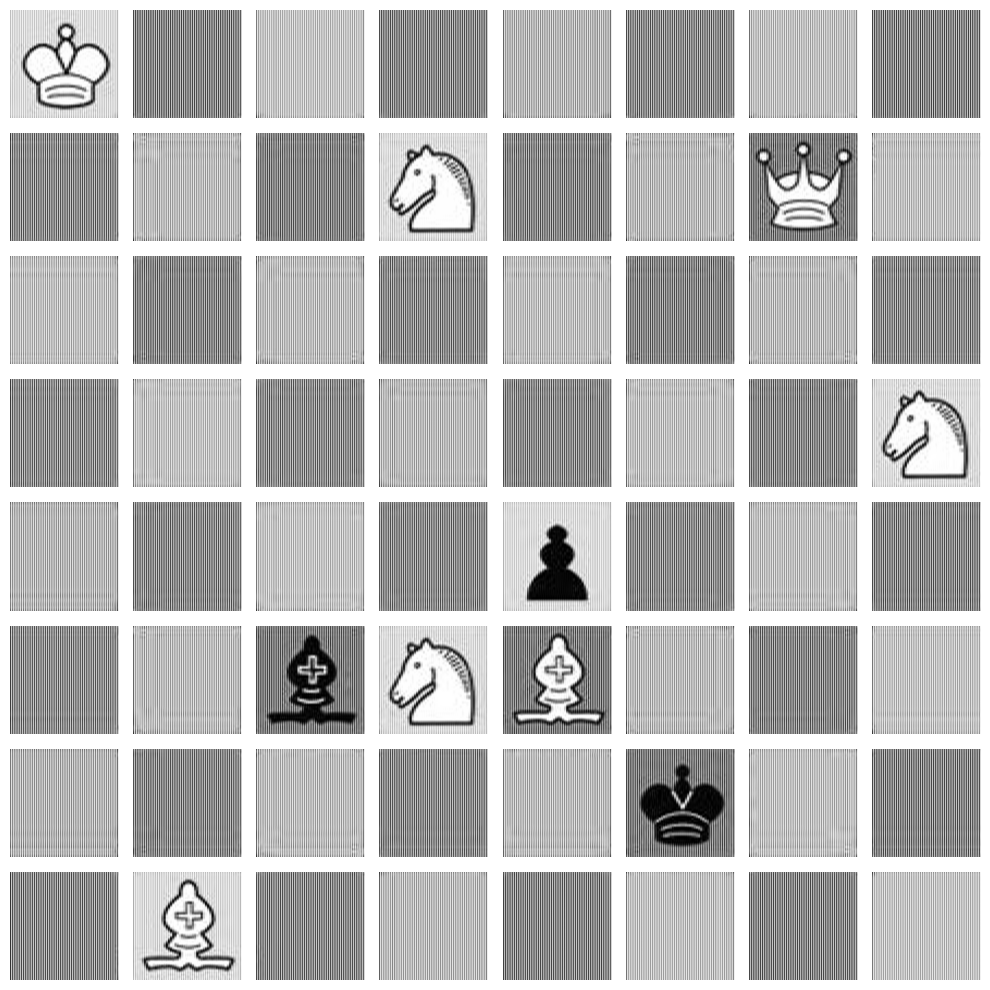

(64, 720, 720)

In [19]:

def image_to_squares_pca(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      new_img =img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8]
      new_img=new_img.reshape(new_img.shape[0], (new_img.shape[1]*new_img.shape[2]))
      new_img= cv2.resize(new_img, (720, 720),interpolation=cv2.INTER_CUBIC)
      squares.append(new_img)
  return np.array(squares)

img = np.array(cv2.imread(samples[8]))
sqaures= image_to_squares_pca(img,400,400)
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

- PCA Analysis - **Components Analysis**

Using 5 components reservers 99.8% of the features


Text(0, 0.5, 'Cumulative_explained_variance')

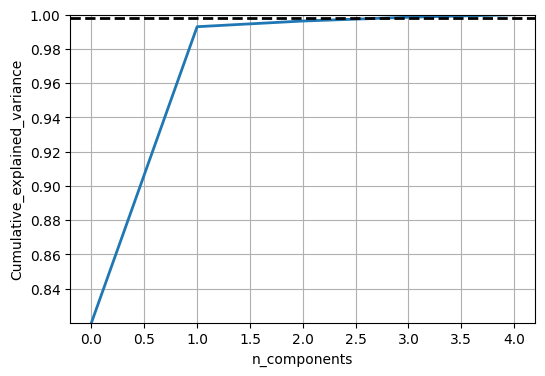

In [20]:
#Import required modules
from sklearn.decomposition import PCA
test_sample= sqaures[3]
pca = PCA()
pca.n_components = 5
img_transformed = pca.fit_transform(test_sample)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

reserved =np.round(np.sum(pca.explained_variance_ratio_),3)*100

print("Using {} components reservers {}% of the features".format(pca.n_components,reserved))

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylim(min(cum_var_explained),1)
plt.axhline(y=reserved/100.0, linestyle='--', color='k', linewidth=2)
plt.ylabel('Cumulative_explained_variance')



- PCA Analysis - **Results**

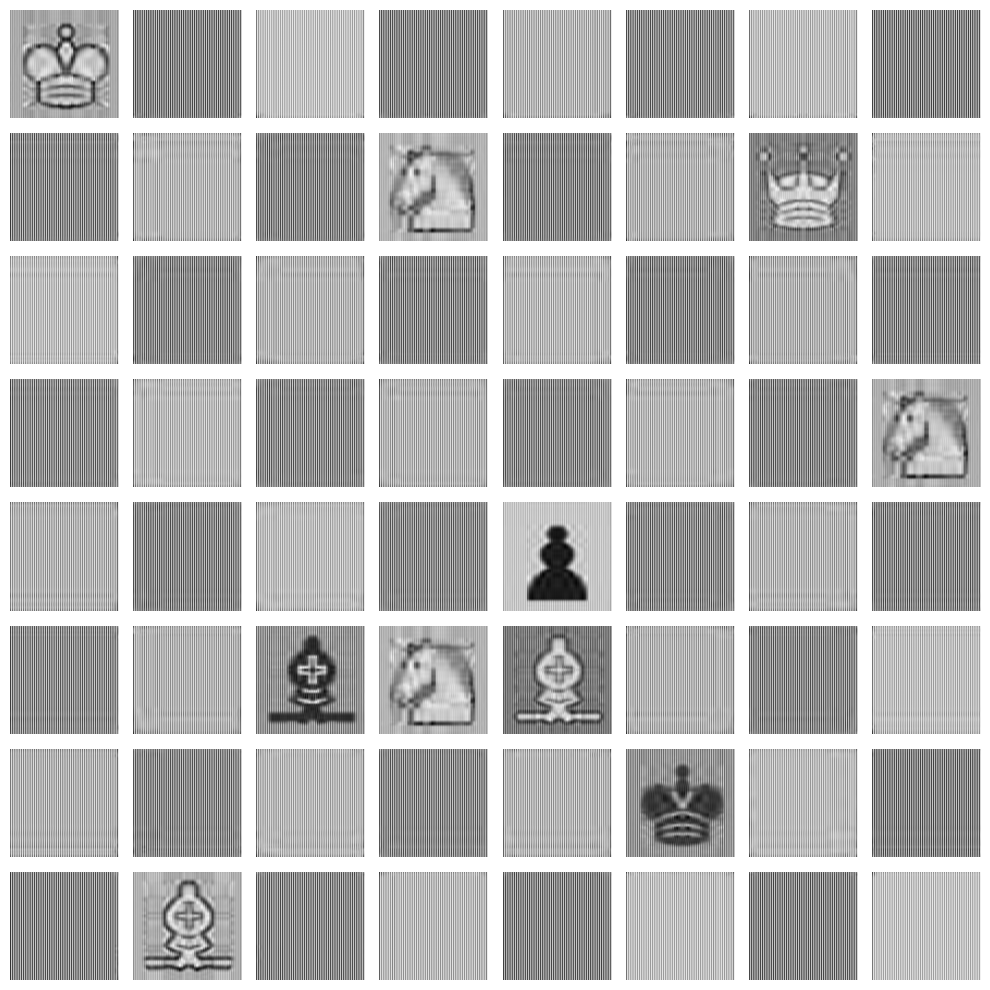

In [21]:
#Import required modules
from sklearn.decomposition import PCA
sqaures_PCA=[]
for img in sqaures:
    pca = PCA()
    pca.n_components = 5
    img_transformed = pca.fit_transform(img)
    temp = pca.inverse_transform(img_transformed)
    temp = np.reshape(temp, (720,720))
    sqaures_PCA.append(temp)

fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures_PCA):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()




### 3 - Feature Engineering

In [22]:
def image_to_squares(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      squares.append(img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8])
  return np.array(squares)

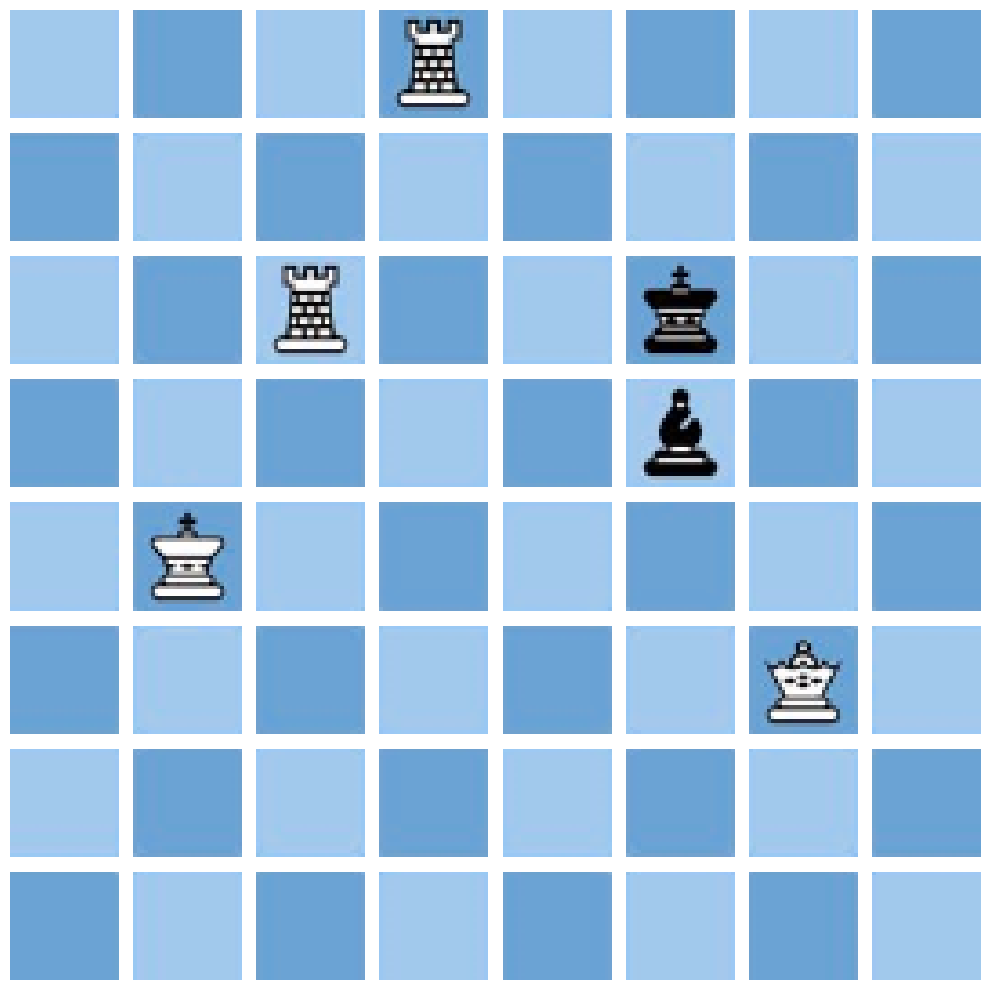

(64, 30, 30, 3)

In [23]:
sqaures= image_to_squares(preprocessed_imgs[0],240,240)
fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

- Create a function to the complete preprocessing and sqaures division of one sample of the data

In [24]:
def preprocess_image(img_path):
    height =240
    width =240

    # change to Grey scal
    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)

    # resize the image to the desired size
    gray_image = cv2.resize(img, (width, height))

    # Normalize the image
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    squares = image_to_squares(gray_image,height,width)
    return squares

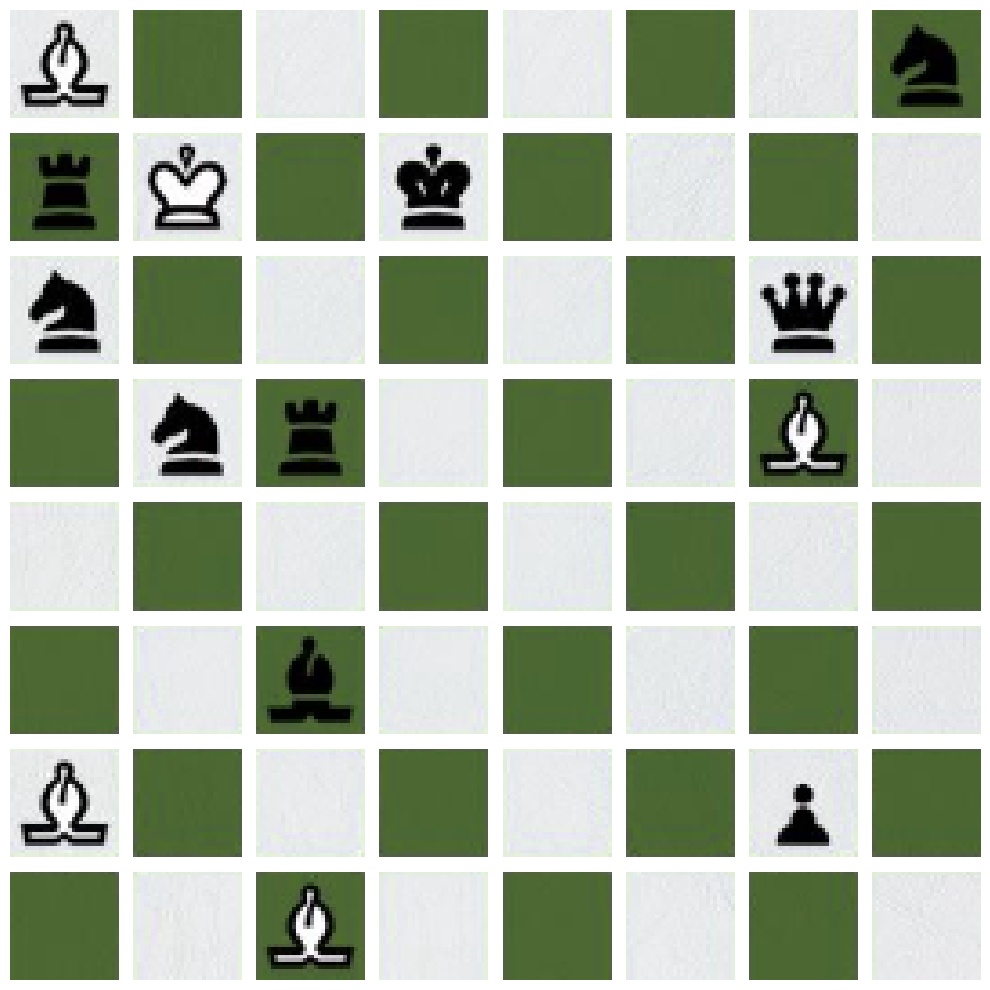

(64, 30, 30, 3)

In [25]:
sqaures=preprocess_image(train[444])

fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8
for i, img in zip(range(1, columns*rows +1),sqaures):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
plt.show()
sqaures.shape

- Create a FEN Label Encode /Decoder Functions
- **NOTE** These 2 Functions are taken from this Kaggle notebook : https://www.kaggle.com/code/koryakinp/chess-fen-generator/notebook

In [26]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

- Create a function divide the data into training and testing sets

In [27]:
def train_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

def pred_gen(features):
    for i, img in enumerate(features):
        y = onehot_from_fen(get_image_FEN_label(img))
        x = preprocess_image(img)
        yield x, y

### 4 - Modeling & Model Training

In [28]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Add a convolutional layer
model = Sequential()
model.add(Convolution2D(32, (3, 3),activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(16, (5, 5),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 16)       │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │         5,213 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,925 (73.93 KB)

 Trainable params: 18,925 (73.93 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
# Fit parameters
EPOCHS=100

print("\nTraining Progress:\n------------------------")
hist = model.fit(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,
                           validation_data=pred_gen(test), validation_steps=test_size//EPOCHS)


Training Progress:
------------------------
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7777 - loss: 1.0271 - val_accuracy: 0.8500 - val_loss: 0.4431
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8801 - loss: 0.4117 - val_accuracy: 0.9359 - val_loss: 0.2430
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9150 - loss: 0.3051 - val_accuracy: 0.9406 - val_loss: 0.2129
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9291 - loss: 0.2298 - val_accuracy: 0.9664 - val_loss: 0.1225
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9622 - loss: 0.1341 - val_accuracy: 0.9699 - val_loss: 0.1028
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9680 - loss: 0.1129 - val_accuracy: 0.9816 - val_loss: 0.0709
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9756 - loss: 0.0804 - val_accuracy: 0.9855 - val_loss: 0.0523
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

2025-01-16 12:57:39.441928: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [32]:
#- Save Model
model.save('./working/models/chess_model.h5')

### 5 - Model Evaluation & Model Tuning

- Model Evaluation - **Loss**

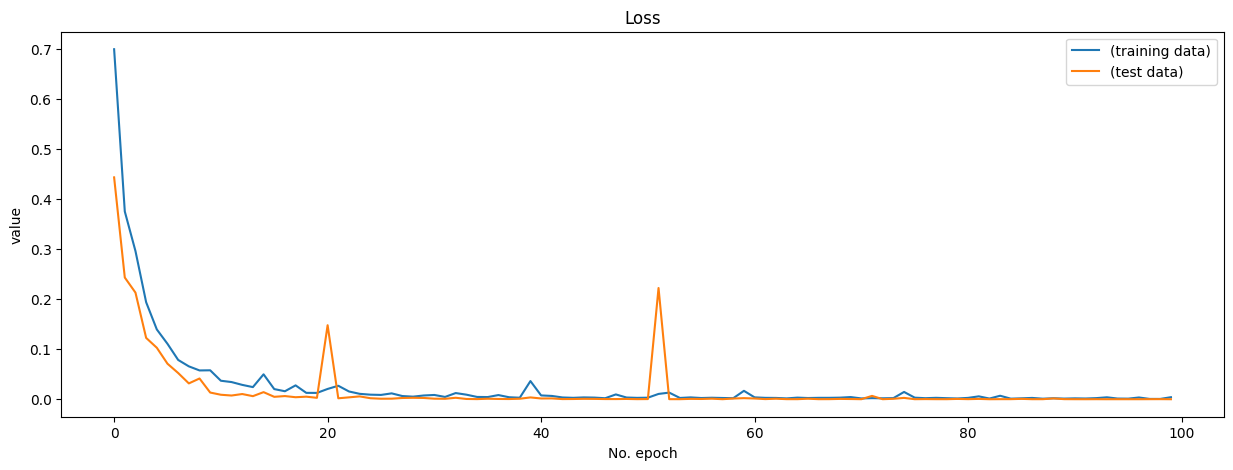

In [33]:
fig = plt.figure(figsize=(15, 5))
plt.plot(hist.history['loss'], label='(training data)')
plt.plot(hist.history['val_loss'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.title('Loss')
plt.show()

- Model Evaluation - **Accuracy**

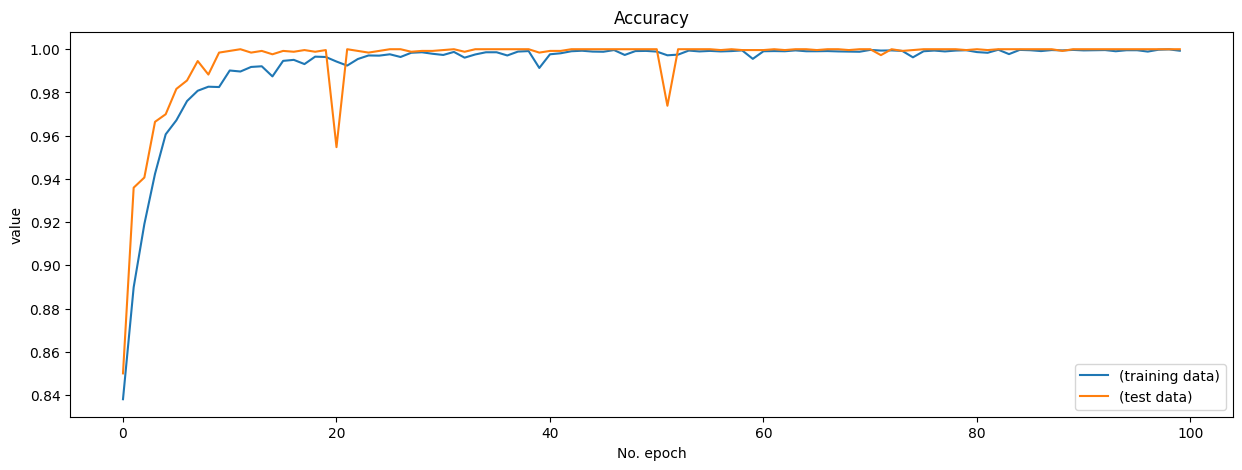

In [34]:
fig = plt.figure(figsize=(15, 5))
plt.plot(hist.history['accuracy'], label='(training data)')
plt.plot(hist.history['val_accuracy'], label='(test data)')

plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.title('Accuracy')
plt.show()

- Prediction - **Prediction**

In [36]:
res = (
  model.predict(pred_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


- Model Evaluation - **All metrics**

In [37]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([get_image_FEN_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99975%


In [38]:
print("\nConfusion Matrix:\n------------------------")
confusion_matrix(test_fens, pred_fens)


Confusion Matrix:
------------------------


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [39]:
print("Precison:", precision_score(test_fens, pred_fens, average='weighted'))
print("Recall:", recall_score(test_fens, pred_fens, average='weighted'))
print("F1 Score:", f1_score(test_fens, pred_fens, average='weighted'))
print("Accuracy:", accuracy_score(test_fens, pred_fens))

Precison: 0.99975
Recall: 0.99975
F1 Score: 0.99975
Accuracy: 0.99975


### 6 - Preview Predictions and Outliers

- **Correct predictions**

In [40]:
import matplotlib.image as mpimg
def display_with_predicted_fen(image):
    plt.figure(figsize=(5,5))
    pred = model.predict(preprocess_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


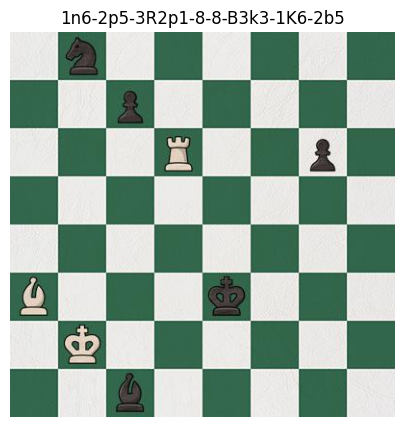

predicted FEN : 1n6-2p5-3R2p1-8-8-B3k3-1K6-2b5


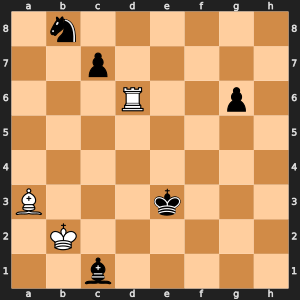

In [41]:
predicted_fen=display_with_predicted_fen(test[230])
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)


- **Outliers ! - Not too many :)**

In [42]:
mask = (pred_fens != test_fens)
predicted_outliers=pred_fens[mask]
outliers=test_fens[mask]
print("how many outliers are there?",len(outliers))

how many outliers are there? 1


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


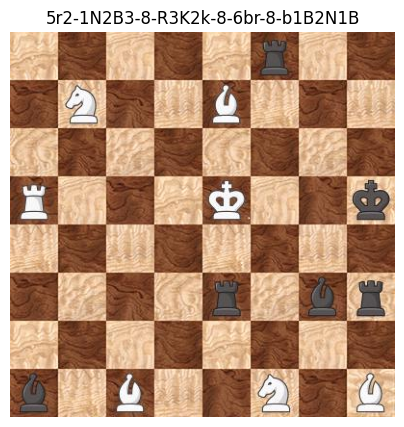

Actual FEN: 5r2-1N2B3-8-R3K2k-8-4r1br-8-b1B2N1B
predicted FEN : 5r2-1N2B3-8-R3K2k-8-6br-8-b1B2N1B


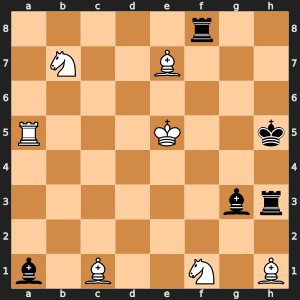

In [44]:
if len(outliers)>0:
    rand = np.random.randint(0, len(outliers))
    predicted_fen=display_with_predicted_fen('./test/'+outliers[rand]+'.jpeg')
    print("Actual FEN: "+outliers[rand])
    print("predicted FEN :",predicted_fen)
    board = chess.Board(predicted_fen.replace('-', '/'))
    display(chess.svg.board(board, size=300))


### 7 - Test Randomly Generated samples of the data

- Function Generator to generate random samples of the data

In [48]:
%pip install cairosvg

Note: you may need to restart the kernel to use updated packages.


- create Directory for randomaly generated pictures

In [51]:
import os
if not os.path.isdir('./working/random/'):
    os.mkdir('./working/random/')

In [54]:
from cairosvg import svg2png
def generate_random_image_from_FEN(FEN,optional_path='./working/random/'):
    board = chess.Board(FEN)
    boardsvg = chess.svg.board(board, size=400,coordinates=False)
    FEN = FEN.replace('/', '-')
    svg2png(bytestring=boardsvg,write_to=optional_path+FEN+'.jpeg')

generate_random_image_from_FEN('2Kp4/2kPbnR1/1p1P1p1P/4Q2q/8/8/P2p1pp1/8')
generate_random_image_from_FEN('8/8/8/8/8/8/8/8')

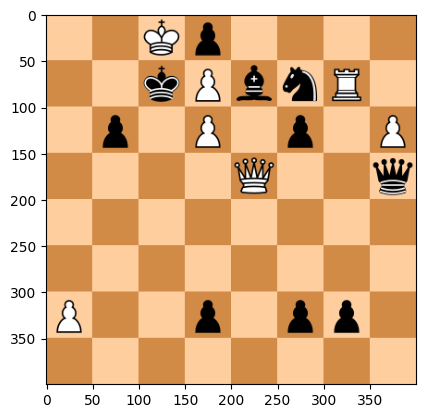

In [55]:
img  = mpimg.imread('./working/random/2Kp4-2kPbnR1-1p1P1p1P-4Q2q-8-8-P2p1pp1-8.jpeg')
plt.imshow(img)

- Test Some Generated Samples of the data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


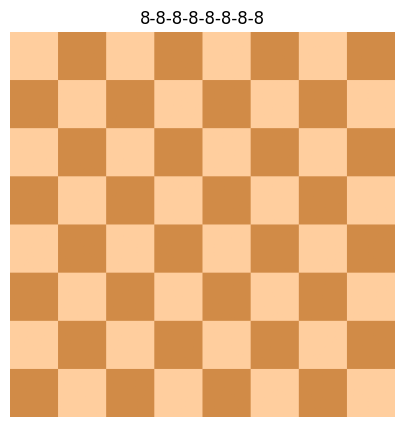

Actual FEN: 8-8-8-8-8-8-8-8
predicted FEN : 8-8-8-8-8-8-8-8


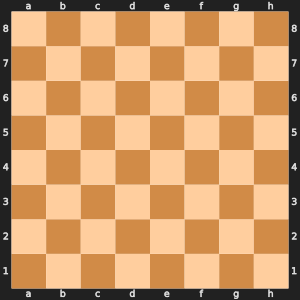

In [56]:
predicted_fen=display_with_predicted_fen('./working/random/'+'8-8-8-8-8-8-8-8'+'.jpeg')
print("Actual FEN: "+'8-8-8-8-8-8-8-8')
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


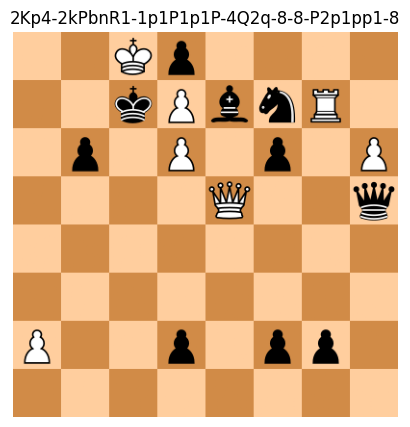

Actual FEN: 2Kp4-2kPbnR1-1p1P1p1P-4Q2q-8-8-P2p1pp1-8
predicted FEN : 2Kp4-2kPbnR1-1p1P1p1P-4Q2q-8-8-P2p1pp1-8


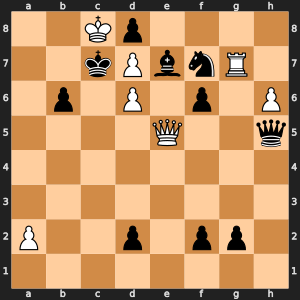

In [57]:
predicted_fen=display_with_predicted_fen('../working/random/'+'2Kp4-2kPbnR1-1p1P1p1P-4Q2q-8-8-P2p1pp1-8'+'.jpeg')
print("Actual FEN: "+'2Kp4-2kPbnR1-1p1P1p1P-4Q2q-8-8-P2p1pp1-8')
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)

### 8 - Model In production

In [59]:
from tensorflow import keras
model_p = keras.models.load_model('./working/models/chess_model.h5')

res = (
  model_p.predict(pred_gen(test), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([get_image_FEN_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
Final Accuracy: 0.99975%


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


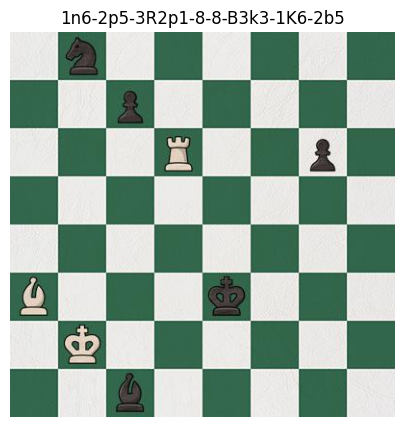

predicted FEN : 1n6-2p5-3R2p1-8-8-B3k3-1K6-2b5


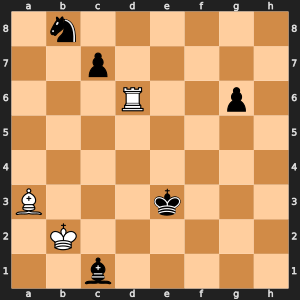

In [60]:
import matplotlib.image as mpimg
def display_with_predicted_fen(image):
    plt.figure(figsize=(5,5))
    pred = model_p.predict(preprocess_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()
    return fen

predicted_fen=display_with_predicted_fen(test[230])
print("predicted FEN :",predicted_fen)
board = chess.Board(predicted_fen.replace('-', '/'))
chess.svg.board(board, size=300)
